In [1]:
# standard
import pandas as pd
import numpy as np
import random

# tf and keras
import tensorflow as tf
#import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# plots
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

# xgboost
import xgboost as xgb
import optuna
import optuna.visualization as vis

random.seed(42)

c:\Users\ashet\anaconda3\envs\ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Read and clean dataframe
df_properties = pd.read_csv('./data/properties_2017.csv')

# Get logerrors of transactions and merge
df_2016 = pd.read_csv('./data/train_2016_v2.csv', parse_dates=["transactiondate"])
df_2017 = pd.read_csv('./data/train_2017.csv', parse_dates=["transactiondate"])
df_logs = pd.concat([df_2016, df_2017])

# Inner join transactions with the dataset of all properties
df_all = pd.merge(df_logs, df_properties, on='parcelid', how='inner')

In [2]:
# Remove some rows missing very important data
df = df_all.dropna(subset=['regionidcounty','landtaxvaluedollarcnt', 'taxamount', 'regionidzip', 'structuretaxvaluedollarcnt'])

# Now we read in the housing index for LA County, and add the index for each month
dfh = pd.read_csv('data/LXXRNSA.csv')
dfh.DATE = pd.to_datetime(dfh.DATE)
df.transactiondate = pd.to_datetime(df.transactiondate)
df['transactionmonth'] =  df['transactiondate'].dt.strftime('%Y%m')
dfh.DATE = dfh['DATE'].dt.strftime('%Y%m')
df = pd.merge(df, dfh, left_on='transactionmonth', right_on='DATE', how='left')
df = df.drop(columns='DATE')

# Get month, year, weekday
df['month'] = df.transactionmonth.str[4:]
df['year'] = df.transactionmonth.str[:-2]
df['weekday'] = df.transactiondate.dt.day_of_week


In [102]:
# Select only certain features from full dataset
X = df[['bedroomcnt','roomcnt','bathroomcnt','taxamount','landtaxvaluedollarcnt','taxvaluedollarcnt','structuretaxvaluedollarcnt',
        'latitude', 'longitude', 'LXXRNSA', 'month', 'year', 'weekday',
          'lotsizesquarefeet', 'calculatedfinishedsquarefeet', 'yearbuilt',
          ]]
Y = df.logerror

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=1234)

# Applying standardization to inputs

numeric_columns = ['bedroomcnt', 'roomcnt', 'bathroomcnt', 'taxamount',
       'landtaxvaluedollarcnt', 'taxvaluedollarcnt',
       'structuretaxvaluedollarcnt', 'latitude', 'longitude', 'LXXRNSA', 
        'lotsizesquarefeet', 'calculatedfinishedsquarefeet', 'yearbuilt',
         ]

# Standardize numeric columns
sc_x = StandardScaler()
X_train_std = X_train.copy()
X_val_std = X_val.copy()

X_train_std[numeric_columns] = sc_x.fit(X_train[numeric_columns]).transform(X_train[numeric_columns])
X_val_std[numeric_columns] = sc_x.fit(X_train[numeric_columns]).transform(X_val[numeric_columns])

# Applying standardization to outputs
Y_train_std = (Y_train - Y_train.mean())/Y_train.std()
Y_val_std = (Y_val - Y_train.mean())/Y_train.std()

# Mask missing data in last three columns - does this help? Apparently a tiny bit
mask_value = -999
X_train_std = X_train_std.fillna(mask_value)
X_val_std = X_val_std.fillna(mask_value)

In [215]:
# THIS IS THE FUNCTION TO PREDICT MAE

y_pred_main = np.zeros(len(Y))

def get_loss(y_true=Y_val_std, y_pred=y_pred_main):
    return tf.keras.losses.MAE(
    y_true, y_pred).numpy()

# Get loss of Zillow model
get_loss(Y, y_pred=y_pred_main)

0.06890573262261189

In [239]:
def build_model(lr, resolution_in_degrees):
    """Use Keras functional API to create neural network model"""
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    random.seed(42)
    mask_value = -999
    

    bedroomcnt = layers.Input(shape=(1,), dtype=tf.float32, name='bedroomcnt')
    roomcnt = layers.Input(shape=(1,), dtype=tf.float32, name='roomcnt')
    bathroomcnt = layers.Input(shape=(1,), dtype=tf.float32, name='bathroomcnt')
    taxamount = layers.Input(shape=(1,), dtype=tf.float32, name='taxamount')
    landtaxvaluedollarcnt = layers.Input(shape=(1,), dtype=tf.float32, name='landtaxvaluedollarcnt')
    taxvaluedollarcnt = layers.Input(shape=(1,), dtype=tf.float32, name='taxvaluedollarcnt')
    structuretaxvaluedollarcnt = layers.Input(shape=(1,), dtype=tf.float32, name='structuretaxvaluedollarcnt')
    latitude = layers.Input(shape=(1,), dtype=tf.float32, name='latitude')
    longitude = layers.Input(shape=(1,), dtype=tf.float32, name='longitude')
    lxxrnsa = layers.Input(shape=(1,), dtype=tf.float32, name='lxxrnsa')
    month = layers.Input(shape=(1,), dtype=tf.string, name='month')
    year = layers.Input(shape=(1,), dtype=tf.string, name='year')
    weekday = layers.Input(shape=(1,), dtype=tf.int64, name='weekday')

    
    lotsizesquarefeet = layers.Input(shape=(1,), dtype=tf.float32, name='lotsizesquarefeet')
    lotsizemask = layers.Masking(mask_value=mask_value)(lotsizesquarefeet)

    calculatedfinishedsquarefeet = layers.Input(shape=(1,), dtype=tf.float32, name='calculatedfinishedsquarefeet')
    finishedsqftmask = layers.Masking(mask_value=mask_value)(calculatedfinishedsquarefeet)

    yearbuilt = layers.Input(shape=(1,), dtype=tf.float32, name='yearbuilt')
    yearblt = layers.Masking(mask_value=mask_value)(yearbuilt)

    bedroomcnt_masked = layers.Masking(mask_value=mask_value)(bedroomcnt)
    roomcnt_masked = layers.Masking(mask_value=mask_value)(roomcnt)
    bathroomcnt_masked = layers.Masking(mask_value=mask_value)(bathroomcnt)
    taxamount_masked = layers.Masking(mask_value=mask_value)(taxamount)
    landtaxvaluedollarcnt_masked = layers.Masking(mask_value=mask_value)(landtaxvaluedollarcnt)
    taxvaluedollarcnt_masked = layers.Masking(mask_value=mask_value)(taxvaluedollarcnt)
    structuretaxvaluedollarcnt_masked = layers.Masking(mask_value=mask_value)(structuretaxvaluedollarcnt)

    # One hot encode month, year and weekday
    month_id = tf.keras.layers.StringLookup(
      vocabulary=['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 
      output_mode='one_hot')(month)
    
    year_id = tf.keras.layers.StringLookup(
      vocabulary=['2016', '2017'], 
      output_mode='one_hot')(year)   

    weekday_id = tf.keras.layers.IntegerLookup(
      vocabulary=[0,1,2,3,4,5,6], 
      output_mode='one_hot')(weekday) 


    # Create a list of numbers representing the bucket boundaries for latitude.
    latitude_boundaries = list(np.arange(-3, 3 + resolution_in_degrees, resolution_in_degrees))

    # Create a Discretization layer to separate the latitude data into buckets.
    latitude_discretized = tf.keras.layers.Discretization(
        bin_boundaries=latitude_boundaries,
        name='discretization_latitude')(latitude)

    # Create a list of numbers representing the bucket boundaries for longitude.
    longitude_boundaries = list(np.arange(-3, 3 + resolution_in_degrees, resolution_in_degrees))

    # Create a Discretization layer to separate the longitude data into buckets.
    longitude_discretized = tf.keras.layers.Discretization(
        bin_boundaries=longitude_boundaries,
        name='discretization_longitude')(longitude)

    # Cross the latitude and longitude features into a single one-hot vector.
    feature_cross = tf.keras.layers.HashedCrossing(
        num_bins=len(latitude_boundaries) * len(longitude_boundaries),
        output_mode='one_hot',
        name='cross_latitude_longitude')([latitude_discretized, longitude_discretized])

    features = layers.Concatenate()([
                    bedroomcnt_masked, 
                    roomcnt_masked, 
                    bathroomcnt_masked, 
                    taxamount_masked, 
                    landtaxvaluedollarcnt_masked, 
                    taxvaluedollarcnt_masked, 
                    structuretaxvaluedollarcnt_masked,
                    feature_cross,
                    lxxrnsa,
                    month_id,
                    year_id,
                    weekday_id,
                    lotsizemask,
                    finishedsqftmask,
                    yearblt,
    ]) 

    x = layers.Dense(units=600, kernel_initializer='normal', activation='relu')(features)
    x = layers.Dropout(0.36)(x)
    x = layers.Dense(units=200, kernel_initializer='normal', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.6)(x)
    x = layers.Dense(1, kernel_initializer='normal')(x)
    x = layers.Dense(1, kernel_initializer='normal')(x)

    logerror = tf.keras.layers.Dense(
        units=1, activation='linear', name='logerror')(x)

    model = tf.keras.Model(inputs=[
        bedroomcnt, 
        roomcnt, 
        bathroomcnt, 
        taxamount, 
        landtaxvaluedollarcnt, 
        taxvaluedollarcnt, 
        structuretaxvaluedollarcnt,
        latitude,
        longitude,
        lxxrnsa,
        month,
        year,
        weekday,
        lotsizesquarefeet,
        calculatedfinishedsquarefeet,
        yearbuilt,
    ], outputs=logerror)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='mae',
        metrics=['mae'])

    return model

In [240]:
model = build_model(lr=0.001, resolution_in_degrees=0.239)
#model.summary()
#display(tf.keras.utils.plot_model(model))
random.seed(42)
tf.random.set_seed(1234)

# Fit model
history = model.fit(
    x={
        'bedroomcnt': X_train_std[['bedroomcnt']],
        'roomcnt': X_train_std[['roomcnt']],
        'bathroomcnt': X_train_std[['bathroomcnt']],
        'taxamount': X_train_std[['taxamount']],
        'landtaxvaluedollarcnt': X_train_std[['landtaxvaluedollarcnt']],
        'taxvaluedollarcnt': X_train_std[['taxvaluedollarcnt']],
        'structuretaxvaluedollarcnt': X_train_std[['structuretaxvaluedollarcnt']],
        'latitude': X_train_std[['latitude']],
        'longitude': X_train_std[['longitude']],
        'lxxrnsa': X_train_std[['LXXRNSA']],
        'year': X_train_std[['year']],  
        'month': X_train_std[['month']],  
        'weekday': X_train_std[['weekday']],
        'lotsizesquarefeet': X_train_std[['lotsizesquarefeet']],
        'calculatedfinishedsquarefeet': X_train_std[['calculatedfinishedsquarefeet']],
        'yearbuilt': X_train_std[['yearbuilt']],

    },
    y=Y_train_std,
    epochs=10,
    batch_size=2000,
    validation_data=(
        {
            'bedroomcnt': X_val_std[['bedroomcnt']],
            'roomcnt': X_val_std[['roomcnt']],
            'bathroomcnt': X_val_std[['bathroomcnt']],
            'taxamount': X_val_std[['taxamount']],
            'landtaxvaluedollarcnt': X_val_std[['landtaxvaluedollarcnt']],
            'taxvaluedollarcnt': X_val_std[['taxvaluedollarcnt']],
            'structuretaxvaluedollarcnt': X_val_std[['structuretaxvaluedollarcnt']],
            'latitude': X_val_std[['latitude']],
            'longitude': X_val_std[['longitude']],
            'lxxrnsa': X_val_std[['LXXRNSA']],
            'year': X_val_std[['year']], 
            'month': X_val_std[['month']], 
            'weekday': X_val_std[['weekday']],
            'lotsizesquarefeet': X_val_std[['lotsizesquarefeet']],
            'calculatedfinishedsquarefeet': X_val_std[['calculatedfinishedsquarefeet']],
            'yearbuilt': X_val_std[['yearbuilt']],
        },
        Y_val_std
    )
)

Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - loss: 0.4193 - mae: 0.4193 - val_loss: 0.4227 - val_mae: 0.4227
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.4166 - mae: 0.4166 - val_loss: 0.4222 - val_mae: 0.4222
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 0.4163 - mae: 0.4163 - val_loss: 0.4217 - val_mae: 0.4217
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - loss: 0.4161 - mae: 0.4161 - val_loss: 0.4213 - val_mae: 0.4213
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.4160 - mae: 0.4160 - val_loss: 0.4210 - val_mae: 0.4210
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.4158 - mae: 0.4158 - val_loss: 0.4208 - val_mae: 0.4208
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - loss: 0.4156 - mae: 0.4156 - val_loss: 0.4207 - val_mae: 0.4207
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - loss: 0.4156 - mae: 0.4156 - val_loss: 0.4207 - val_mae: 0.4207
Epoch 9/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - lo

In [ ]:
train_x = {
        'bedroomcnt': X_train_std[['bedroomcnt']],
        'roomcnt': X_train_std[['roomcnt']],
        'bathroomcnt': X_train_std[['bathroomcnt']],
        'taxamount': X_train_std[['taxamount']],
        'landtaxvaluedollarcnt': X_train_std[['landtaxvaluedollarcnt']],
        'taxvaluedollarcnt': X_train_std[['taxvaluedollarcnt']],
        'structuretaxvaluedollarcnt': X_train_std[['structuretaxvaluedollarcnt']],
        'latitude': X_train_std[['latitude']],
        'longitude': X_train_std[['longitude']],
        'lxxrnsa': X_train_std[['LXXRNSA']],
        'year': X_train_std[['year']],  
        'month': X_train_std[['month']],  
        'weekday': X_train_std[['weekday']],
        'lotsizesquarefeet': X_train_std[['lotsizesquarefeet']],
        'calculatedfinishedsquarefeet': X_train_std[['calculatedfinishedsquarefeet']],
        'yearbuilt': X_train_std[['yearbuilt']],

    }

val_x = {
            'bedroomcnt': X_val_std[['bedroomcnt']],
            'roomcnt': X_val_std[['roomcnt']],
            'bathroomcnt': X_val_std[['bathroomcnt']],
            'taxamount': X_val_std[['taxamount']],
            'landtaxvaluedollarcnt': X_val_std[['landtaxvaluedollarcnt']],
            'taxvaluedollarcnt': X_val_std[['taxvaluedollarcnt']],
            'structuretaxvaluedollarcnt': X_val_std[['structuretaxvaluedollarcnt']],
            'latitude': X_val_std[['latitude']],
            'longitude': X_val_std[['longitude']],
            'lxxrnsa': X_val_std[['LXXRNSA']],
            'year': X_val_std[['year']], 
            'month': X_val_std[['month']], 
            'weekday': X_val_std[['weekday']],
            'lotsizesquarefeet': X_val_std[['lotsizesquarefeet']],
            'calculatedfinishedsquarefeet': X_val_std[['calculatedfinishedsquarefeet']],
            'yearbuilt': X_val_std[['yearbuilt']],
        }

# Define the objective function
def objective(trial):

    lr = trial.suggest_float("lr", 0.0005, 0.005)
    resolution_in_degrees = trial.suggest_float("resolution_in_degrees", 0.05, 0.7)
    epochs = trial.suggest_int("epochs", 5, 10)
    batch = trial.suggest_int("batch", 4000, 10000)

    random.seed(42)
    tf.random.set_seed(1234)
    

    model = build_model(lr, resolution_in_degrees)
  
    # Train the model
    history = model.fit(
    x=train_x,
    y=Y_train_std,
    epochs= epochs,
    batch_size=batch,
    validation_data=(val_x, Y_val_std),
    verbose = 0,
)
    
    # Return the final validation MAE
    val_mae = history.history['val_mae'][-1]
    return val_mae

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, timeout=900)

# Print the best parameters
print(f"Best Parameters: {study.best_params}")


In [114]:
val_preds = model.predict({
        'bedroomcnt': X_val_std[['bedroomcnt']],
        'roomcnt': X_val_std[['roomcnt']],
        'bathroomcnt': X_val_std[['bathroomcnt']],
        'taxamount': X_val_std[['taxamount']],
        'landtaxvaluedollarcnt': X_val_std[['landtaxvaluedollarcnt']],
        'taxvaluedollarcnt': X_val_std[['taxvaluedollarcnt']],
        'structuretaxvaluedollarcnt': X_val_std[['structuretaxvaluedollarcnt']],
        'latitude': X_val_std[['latitude']],
        'longitude': X_val_std[['longitude']],
        'lxxrnsa': X_val_std[['LXXRNSA']],
        'year': X_val_std[['year']], 
        'month': X_val_std[['month']],
        'weekday': X_val_std[['weekday']],
        'lotsizesquarefeet': X_val_std[['lotsizesquarefeet']],
        'calculatedfinishedsquarefeet': X_val_std[['calculatedfinishedsquarefeet']],
        'yearbuilt': X_val_std[['yearbuilt']],
        
    })

# Convert to regular scale from scaled-standardized scale and print loss
val_preds= (val_preds[:,0]*Y_train.std()) + Y_train.mean()
get_loss(y_pred=val_preds, y_true=Y_val)

1046/1046 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


0.06903582

### XGBoost

In [119]:
# Get train and validation predictions from neural network as inputs for XGBoost

train_preds = model.predict({
        'bedroomcnt': X_train_std[['bedroomcnt']],
        'roomcnt': X_train_std[['roomcnt']],
        'bathroomcnt': X_train_std[['bathroomcnt']],
        'taxamount': X_train_std[['taxamount']],
        'landtaxvaluedollarcnt': X_train_std[['landtaxvaluedollarcnt']],
        'taxvaluedollarcnt': X_train_std[['taxvaluedollarcnt']],
        'structuretaxvaluedollarcnt': X_train_std[['structuretaxvaluedollarcnt']],
        'latitude': X_train_std[['latitude']],
        'longitude': X_train_std[['longitude']],
        'lxxrnsa': X_train_std[['LXXRNSA']],
        'year': X_train_std[['year']],  
        'month': X_train_std[['month']],  
        'weekday': X_train_std[['weekday']],
        'lotsizesquarefeet': X_train_std[['lotsizesquarefeet']],
        'calculatedfinishedsquarefeet': X_train_std[['calculatedfinishedsquarefeet']],
        'yearbuilt': X_train_std[['yearbuilt']],
    })

val_preds = model.predict({
        'bedroomcnt': X_val_std[['bedroomcnt']],
        'roomcnt': X_val_std[['roomcnt']],
        'bathroomcnt': X_val_std[['bathroomcnt']],
        'taxamount': X_val_std[['taxamount']],
        'landtaxvaluedollarcnt': X_val_std[['landtaxvaluedollarcnt']],
        'taxvaluedollarcnt': X_val_std[['taxvaluedollarcnt']],
        'structuretaxvaluedollarcnt': X_val_std[['structuretaxvaluedollarcnt']],
        'latitude': X_val_std[['latitude']],
        'longitude': X_val_std[['longitude']],
        'lxxrnsa': X_val_std[['LXXRNSA']],
        'year': X_val_std[['year']], 
        'month': X_val_std[['month']],
        'weekday': X_val_std[['weekday']],
        'lotsizesquarefeet': X_val_std[['lotsizesquarefeet']],
        'calculatedfinishedsquarefeet': X_val_std[['calculatedfinishedsquarefeet']],
        'yearbuilt': X_val_std[['yearbuilt']],
    })



4181/4181 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step


In [153]:
# Create XGBoost matrices
d_train = xgb.DMatrix(train_preds, label = Y_train_std)
d_valid = xgb.DMatrix(val_preds, label = Y_val_std)

In [154]:
# Train XGBoost model
params = {}
params['eta'] = 0.02
params['objective'] = 'reg:squarederror'
params['eval_metric'] = 'mae'
params['max_depth'] = 1
params['silent'] = 1

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
clf = xgb.train(params, d_train, 120, watchlist,
                early_stopping_rounds=100, verbose_eval=10)

[0]	train-mae:0.41944	valid-mae:0.42693


c:\Users\ashet\anaconda3\envs\ml\Lib\site-packages\xgboost\core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\ashet\anaconda3\envs\ml\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:44:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	train-mae:0.41889	valid-mae:0.42643
[20]	train-mae:0.41852	valid-mae:0.42609
[30]	train-mae:0.41825	valid-mae:0.42583
[40]	train-mae:0.41803	valid-mae:0.42562
[50]	train-mae:0.41788	valid-mae:0.42547
[60]	train-mae:0.41774	valid-mae:0.42534
[70]	train-mae:0.41764	valid-mae:0.42524
[80]	train-mae:0.41756	valid-mae:0.42517
[90]	train-mae:0.41749	valid-mae:0.42511
[100]	train-mae:0.41743	valid-mae:0.42505
[110]	train-mae:0.41738	valid-mae:0.42502
[119]	train-mae:0.41735	valid-mae:0.42499


In [155]:
# Get final loss, it's not significantly better
forest_val = (clf.predict(d_valid)*Y_train.std()) + Y_train.mean()
get_loss(y_pred=forest_val, y_true=Y_val1)

0.069770075

### Hyperparameter Tuning

In [156]:

# Define the objective function
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'eta': trial.suggest_float('eta', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True)
    }
        
    # Train the model
    model = xgb.train(params, d_train, num_boost_round=1000, evals=watchlist,
                      early_stopping_rounds=100, verbose_eval=False)
    
    # Return the best validation MAE
    val_mae = model.best_score
    return val_mae

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, timeout=600)

# Print the best parameters
print(f"Best Parameters: {study.best_params}")


[I 2024-08-06 17:45:15,780] A new study created in memory with name: no-name-ac48070c-43ec-4e6d-8fe4-fad3e92563f6
[I 2024-08-06 17:45:18,640] Trial 0 finished with value: 0.4250122785152996 and parameters: {'eta': 0.02408685983723347, 'max_depth': 4, 'subsample': 0.9660363932938789, 'colsample_bytree': 0.6404704609861492, 'lambda': 0.006204604532392792, 'alpha': 1.209864274636887e-07}. Best is trial 0 with value: 0.4250122785152996.
[I 2024-08-06 17:45:21,276] Trial 1 finished with value: 0.42488807513324073 and parameters: {'eta': 0.03100460724677393, 'max_depth': 3, 'subsample': 0.822923699891477, 'colsample_bytree': 0.6753075248961763, 'lambda': 0.00012662333084381534, 'alpha': 0.281886846203796}. Best is trial 1 with value: 0.42488807513324073.
[I 2024-08-06 17:45:24,045] Trial 2 finished with value: 0.42583106763654893 and parameters: {'eta': 0.08263512146721413, 'max_depth': 13, 'subsample': 0.997356214918908, 'colsample_bytree': 0.7460585052564457, 'lambda': 2.1079012828436545e-

Best Parameters: {'eta': 0.050558095111528936, 'max_depth': 2, 'subsample': 0.6044757738963972, 'colsample_bytree': 0.7915810927294245, 'lambda': 2.6668637634463312e-05, 'alpha': 9.50225885655121e-06}


In [161]:
best_opts= {'eta': 0.050558095111528936, 
            'max_depth': 1, 
            'subsample': 0.6044757738963972, 
            'colsample_bytree': 0.7915810927294245, 
            'lambda': 2.6668637634463312e-05, 
            'alpha': 9.50225885655121e-06,
                'eval_metric' : 'mae'}


In [167]:
# Train best XGBoost model
clf = xgb.train(
    best_opts,
    d_train,
    num_boost_round=72,  # Choose a suitable number of boosting rounds
    evals=watchlist,
    early_stopping_rounds=100,
    verbose_eval=10
)

[0]	train-mae:0.41934	valid-mae:0.42684
[10]	train-mae:0.41831	valid-mae:0.42591
[20]	train-mae:0.41780	valid-mae:0.42541
[30]	train-mae:0.41750	valid-mae:0.42514
[40]	train-mae:0.41733	valid-mae:0.42500
[50]	train-mae:0.41729	valid-mae:0.42497
[60]	train-mae:0.41723	valid-mae:0.42489
[70]	train-mae:0.41716	valid-mae:0.42483
[71]	train-mae:0.41716	valid-mae:0.42483


In [222]:
# Get final loss, it's near-identical
xgb_val = (clf.predict(d_valid)*Y_train.std()) + Y_train.mean()
get_loss(y_pred=xgb_val, y_true=Y_val)

0.06974488

In [245]:
# Optimization history plot
opt_history_fig = vis.plot_optimization_history(study)
opt_history_fig.show()

In [ ]:
# Parameter importance plot
param_importance_fig = vis.plot_param_importances(study)
param_importance_fig.show()

In [ ]:
# Slice plot
slice_fig = vis.plot_slice(study)
slice_fig.show()

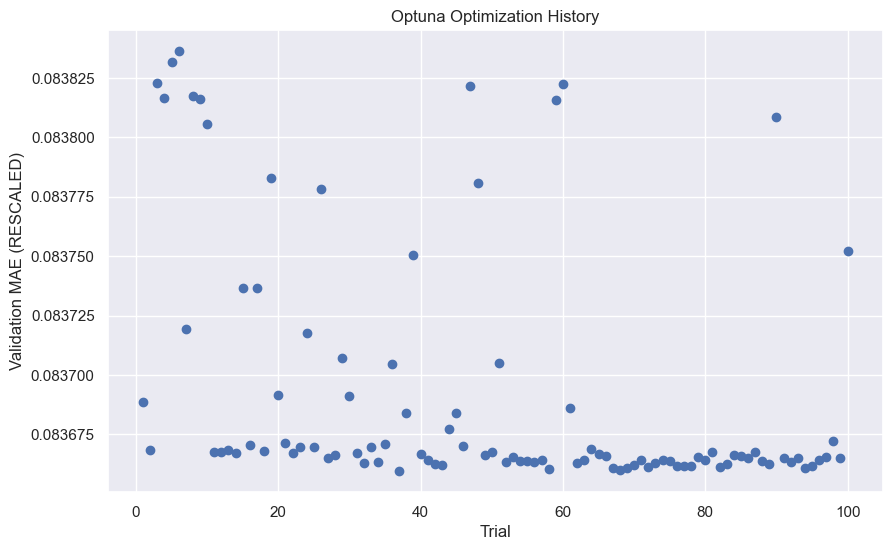

In [247]:
# Extract values from the study
trial_values = [trial.value for trial in study.trials]

# Apply the transformation: (value * a) + b
transformed_values = [(value * Y_train.std()) + Y_train.mean() for value in trial_values]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(range(1,101,1), transformed_values)
plt.xlabel('Trial')
plt.ylabel('Validation MAE (RESCALED)')
plt.title('Optuna Optimization History')
plt.grid(True)
plt.show()

### Create test data

In [9]:
sample = pd.read_csv('./data/sample_submission.csv')
sample

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0,0,0,0,0,0
1,10759547,0,0,0,0,0,0
2,10843547,0,0,0,0,0,0
3,10859147,0,0,0,0,0,0
4,10879947,0,0,0,0,0,0
...,...,...,...,...,...,...,...
2985212,168176230,0,0,0,0,0,0
2985213,14273630,0,0,0,0,0,0
2985214,168040630,0,0,0,0,0,0
2985215,168040830,0,0,0,0,0,0


In [2]:
prop = pd.read_csv('./data/properties_2017.csv')
sample['parcelid'] = sample['ParcelId']
df_test = sample.merge(prop, on='parcelid', how = 'left')

C:\Users\ashet\AppData\Local\Temp\ipykernel_14956\2619332840.py:1: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  prop = pd.read_csv('./data/properties_2017.csv')


In [53]:
# Run on test data

train_columns =  ['bedroomcnt', 'roomcnt', 'bathroomcnt', 'taxamount',
       'landtaxvaluedollarcnt', 'taxvaluedollarcnt',
       'structuretaxvaluedollarcnt', 'latitude', 'longitude',
        'lotsizesquarefeet', 'calculatedfinishedsquarefeet', 'yearbuilt',
         ]
x_test = df_test[train_columns]

# Set the transaction date dependent columns to constants
x_test['LXXRNSA'] = 253.028
x_test['month'] = "12"
x_test['year'] = "2016"
x_test['weekday'] = 4


C:\Users\ashet\AppData\Local\Temp\ipykernel_5348\1250237004.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['LXXRNSA'] = 253.028
C:\Users\ashet\AppData\Local\Temp\ipykernel_5348\1250237004.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['month'] = "12"
C:\Users\ashet\AppData\Local\Temp\ipykernel_5348\1250237004.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [55]:
X_test_std = x_test.copy()

# Scale-standardize features
sc_x = StandardScaler()
sc_x.fit(X_train[numeric_columns])

# Transform the test data using the same fitted scaler
X_test_std[numeric_columns] = sc_x.transform(X_test_std[numeric_columns])

# For latitude and longitude, we can't mask, so fill NAs with zeros
X_test_std.longitude = X_test_std.longitude.fillna(0)
X_test_std.latitude = X_test_std.latitude.fillna(0)

# Mask missing data in columns 
mask_value = -999
X_test_std = X_test_std.fillna(mask_value)

In [117]:
# Generate neural network predictions for all parcel IDs
preds = model.predict({
        'bedroomcnt': X_test_std[['bedroomcnt']],
        'roomcnt': X_test_std[['roomcnt']],
        'bathroomcnt': X_test_std[['bathroomcnt']],
        'taxamount': X_test_std[['taxamount']],
        'landtaxvaluedollarcnt': X_test_std[['landtaxvaluedollarcnt']],
        'taxvaluedollarcnt': X_test_std[['taxvaluedollarcnt']],
        'structuretaxvaluedollarcnt': X_test_std[['structuretaxvaluedollarcnt']],
        'latitude': X_test_std[['latitude']],
        'longitude': X_test_std[['longitude']],
        'lxxrnsa': X_test_std[['LXXRNSA']],
        'year': X_test_std[['year']],  
        'month': X_test_std[['month']],  
        'weekday': X_test_std[['weekday']],
        'lotsizesquarefeet': X_test_std[['lotsizesquarefeet']],
        'calculatedfinishedsquarefeet': X_test_std[['calculatedfinishedsquarefeet']],
        'yearbuilt': X_test_std[['yearbuilt']],
    })

93289/93289 ━━━━━━━━━━━━━━━━━━━━ 2894s 31ms/step


In [58]:
for c in sample.columns[sample.columns != 'ParcelId']:
    sample[c] = ((preds[:,0]*Y_train.std()) + Y_train.mean())


In [59]:
sample

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0.005542,0.005542,0.005542,0.005542,0.005542,0.005542
1,10759547,0.005886,0.005886,0.005886,0.005886,0.005886,0.005886
2,10843547,0.563296,0.563296,0.563296,0.563296,0.563296,0.563296
3,10859147,0.016259,0.016259,0.016259,0.016259,0.016259,0.016259
4,10879947,0.006889,0.006889,0.006889,0.006889,0.006889,0.006889
...,...,...,...,...,...,...,...
2985212,168176230,0.010419,0.010419,0.010419,0.010419,0.010419,0.010419
2985213,14273630,0.011146,0.011146,0.011146,0.011146,0.011146,0.011146
2985214,168040630,0.009144,0.009144,0.009144,0.009144,0.009144,0.009144
2985215,168040830,0.007757,0.007757,0.007757,0.007757,0.007757,0.007757


In [60]:
# Save neural network predictions to csv
sample.to_csv('nn1.csv', index=False, float_format='%.4f')


In [ ]:
# Create XGBoost predictions from neural network predictions
d_test_1 = xgb.DMatrix(preds)
xg_preds_1 = (clf.predict(d_test_1)*Y_train.std()) + Y_train.mean()

In [174]:
for c in sample.columns[sample.columns != 'ParcelId']:
    sample[c] = xg_preds_1

In [175]:
sample

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0.009251,0.009251,0.009251,0.009251,0.009251,0.009251
1,10759547,0.009251,0.009251,0.009251,0.009251,0.009251,0.009251
2,10843547,0.073047,0.073047,0.073047,0.073047,0.073047,0.073047
3,10859147,0.021976,0.021976,0.021976,0.021976,0.021976,0.021976
4,10879947,0.009251,0.009251,0.009251,0.009251,0.009251,0.009251
...,...,...,...,...,...,...,...
2985212,168176230,0.014024,0.014024,0.014024,0.014024,0.014024,0.014024
2985213,14273630,0.014236,0.014236,0.014236,0.014236,0.014236,0.014236
2985214,168040630,0.013153,0.013153,0.013153,0.013153,0.013153,0.013153
2985215,168040830,0.009730,0.009730,0.009730,0.009730,0.009730,0.009730


In [176]:
# Save combination model outputs to csv
sample.to_csv('nn1+xg.csv', index=False, float_format='%.4f')
